## Chapter 16 exercises.

*  Note there is no file for CHapter 15, i skipped those exercises.



In [35]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns
import xarray as xr

## Exercise 16.6 Big words

In [2]:
big_word_club = pd.read_csv("big_word_club.csv", index_col='participant_id')
big_word_club.drop(columns='Unnamed: 0', inplace=True)
big_word_club = big_word_club[big_word_club['treat']==1]
big_word_club = big_word_club[['school_id', 'score_pct_change']].dropna()
big_word_club.head()

,school_id,score_pct_change
participant_id,,
10148,2,-8.823529
16144,2,14.285714
17009,2,17.857143
18848,2,6.666667
25961,2,12.500000


In [3]:
student_counts = big_word_club['school_id'].value_counts().sort_index()

In [81]:
len(student_counts)

26

In [82]:
(student_counts.min(), student_counts.max())

(12, 17)

The data contains 26 schools, with a range of participation from 12 to 17 students.

In [4]:
grouped_pct_change = big_word_club.groupby('school_id').agg(['mean',np.std]).sort_values(('score_pct_change','mean'), ascending = False)
grouped_pct_change.columns = grouped_pct_change.columns.get_level_values(1)  # remove hierarchical
grouped_pct_change

,mean,std
school_id,,
17,15.845327,18.864408
2,15.774316,21.065122
3,15.008155,28.096170
9,13.930778,27.146064
8,12.991398,15.202380
18,11.432666,13.000469
28,10.414026,9.916331
39,8.904240,15.780657
4,8.695859,15.529803


Most improved was School 17 , worst was school 6

Now we want to look at plots of between school and within school variablilty.   I think the best way is to plot each schools mwan with a bar indicating 1 standard deviation error. But first we can also look at the between group variability directly:

In [5]:
(np.mean(grouped_pct_change['mean']), np.std(grouped_pct_change['mean']))

(6.420412522071856, 5.318582910785571)

<AxesSubplot:xlabel='school_id', ylabel='score_pct_change'>

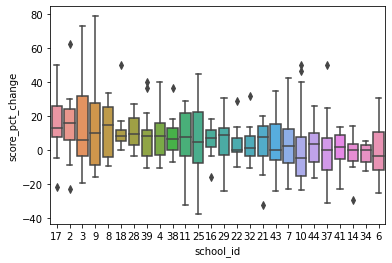

In [85]:
sns.boxplot(data = big_word_club, x = 'school_id', y='score_pct_change', order = grouped_pct_change.index )

## Exercise  16.7

A hierarchical model is appropriate here because we expect that there might be differences by group in the students involved or the implementation of the program. However, the program as a whole was generally the same from school to school and we expect that there would be some common effects as well.

In this model $\mu$  is the average school mean. This would be what we would expect from some new school usign this program. The standard deviation $\sigma_{\mu}$   represents the school to school variability.  Each group has its own mean $\mu_y$ and we model that the standard deviation within a group is $\sigma_y$


## Exercise 16.8

Now comes the simulation of the model. We will use Bambi

In [142]:
model = bmb.Model('score_pct_change ~ (1 | school_id)', big_word_club)

In [143]:
model.build()
model

Formula: score_pct_change ~ (1 | school_id)
Family name: Gaussian
Link: identity
Observations: 336
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 6.2666, sigma: 42.6434)

  Group-level effects
    1|school_id ~ Normal(mu: 0, sigma: HalfNormal(sigma: 42.6434))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 17.0573)

This is fine the aux sigma is pretty narrowly defined, but whateva, pressing on.  Interpration of these things: 

- `sigma` is the within school residual variability $\sigma_y$. 

- `Intercept` is the common level mean $\mu$. 

- `1|school_id` will be many parameters, a mean for each group $\mu_y$. This line actually tells us the prior for   the group level sigma  $\sigma_{\mu}$  . I found this confusing at first

 

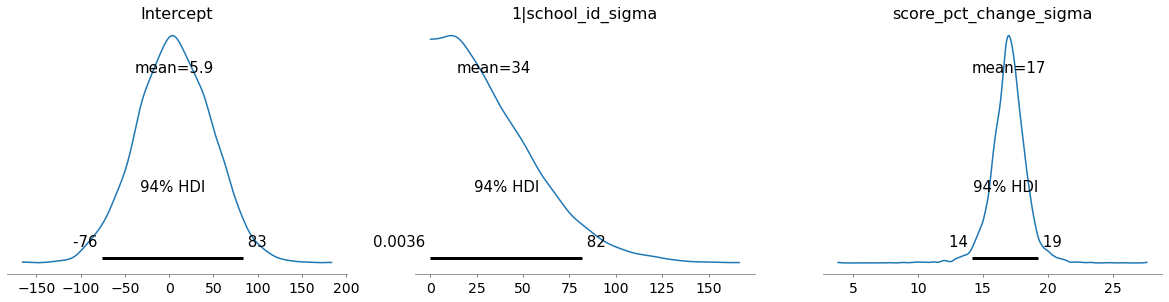

In [112]:
model.plot_priors();

In [144]:
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|school_id_sigma, 1|school_id_offset, score_pct_change_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


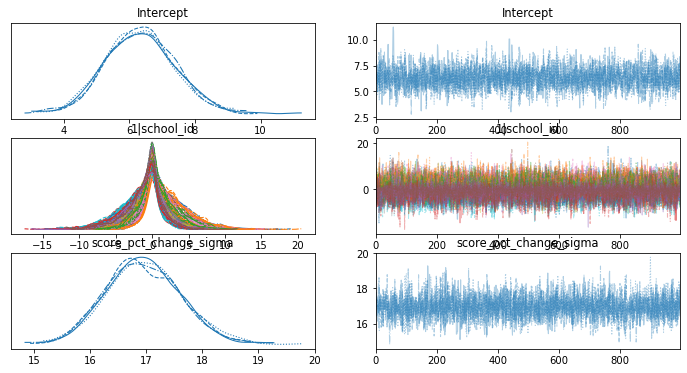

In [9]:
az.plot_trace(results, var_names=["Intercept","1|school_id",'score_pct_change_sigma'], compact=True);

In [134]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.297,1.079,4.292,8.342,0.018,0.013,3468.0,2325.0,1.00
1|school_id_sigma,2.541,1.498,0.011,5.042,0.042,0.030,1220.0,1697.0,1.01
score_pct_change_sigma,16.953,0.680,15.726,18.255,0.011,0.008,3817.0,2374.0,1.00
1|school_id[2],2.120,2.811,-2.030,8.054,0.058,0.042,2456.0,2912.0,1.00
1|school_id[3],2.056,2.777,-2.432,7.461,0.056,0.042,2599.0,2797.0,1.00
1|school_id[4],0.577,2.288,-4.022,5.156,0.033,0.034,4833.0,3198.0,1.00
1|school_id[6],-1.869,2.699,-7.773,2.269,0.051,0.038,2925.0,2921.0,1.00
1|school_id[7],-0.578,2.361,-5.244,3.980,0.036,0.034,4419.0,2657.0,1.00
1|school_id[8],1.512,2.622,-2.877,7.242,0.048,0.041,3296.0,2892.0,1.00
1|school_id[9],1.748,2.711,-2.583,7.418,0.051,0.040,3059.0,2805.0,1.00


Note that the rhats are good and the traces look good.

In [145]:
post_pred = model.predict(results,kind='pps',inplace=False,include_group_specific=True)

<AxesSubplot:xlabel='score_pct_change / score_pct_change'>

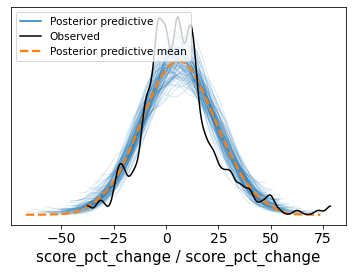

In [146]:
az.plot_ppc(post_pred ,num_pp_samples =100)

Captures the general distribution but the top doesn't quite capture it properly. Or it could be i am using predict wrong

## Exercise 16.9 

Credible intervals are in the summary (using a different interval, but whatevah.)

Since nearly all of the probability density for $\mu$ is greater then zero, there seems to be ample evidence that the program works!

As for variability, within school variablity is much larger then between schools.  This simply is due to the student to student capabliities and willingness to work. These tend to average out somewhat so that school to school variability is less.

## Exercise 16.10 

In [147]:
sum_80 = az.summary(results, hdi_prob=0.8)

sum_80

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.324,1.125,4.980,7.751,0.024,0.017,2363.0,1663.0,1.0
1|school_id_sigma,2.551,1.485,0.151,3.949,0.044,0.031,1123.0,1602.0,1.0
score_pct_change_sigma,16.944,0.668,16.057,17.744,0.010,0.007,4327.0,2786.0,1.0
1|school_id[2],2.174,2.772,-1.244,5.149,0.060,0.043,2252.0,2750.0,1.0
1|school_id[3],2.106,2.836,-1.403,4.997,0.057,0.042,2566.0,2476.0,1.0
1|school_id[4],0.634,2.365,-2.055,3.510,0.041,0.038,3581.0,3053.0,1.0
1|school_id[6],-1.978,2.717,-4.990,1.408,0.056,0.041,2562.0,2616.0,1.0
1|school_id[7],-0.704,2.387,-3.536,2.042,0.040,0.039,3773.0,3045.0,1.0
1|school_id[8],1.541,2.643,-1.712,4.252,0.052,0.038,2721.0,2878.0,1.0
1|school_id[9],1.866,2.696,-1.004,5.127,0.052,0.038,2853.0,3062.0,1.0


Since 80% is quite different i re-ran summary to answer this question.  For school 10, the 80% interval ranges:

In [148]:
mu = sum_80.loc['Intercept','mean']
mu + (sum_80.loc['1|school_id[10]','hdi_10%'],sum_80.loc['1|school_id[10]','hdi_90%'])

array([2.558, 8.042])

This means that there is NOT ample evidence that school10 improved by more then 5%. 

## Exercise 16.11

Here we want to predict future of a student at school 6, 17 and a new school Bayes Prep which we dont have data on.  We could do these manually using the posterior simulations but I am going to skip that part.  It is clear what you need to do.

7.849448494199026
16.841920842369717


<AxesSubplot:>

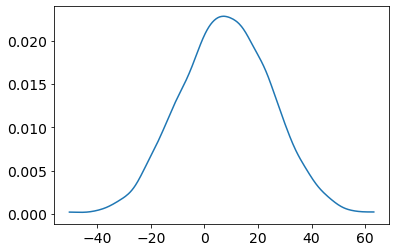

In [240]:
school17 = model.predict(results, kind='pps', data = pd.DataFrame({'school_id' : [17]}),include_group_specific=True,inplace=False)
data = school17.posterior_predictive.score_pct_change.values.flatten()
print(np.mean(data))
print(np.std(data))
az.plot_dist(data)

4.42529827394906
17.284386027078757


<AxesSubplot:>

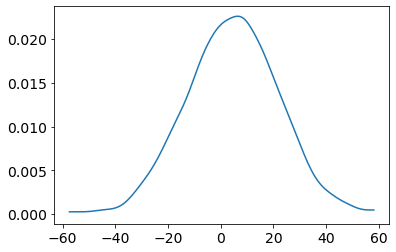

In [249]:
school6 = model.predict(results, kind='pps', data = pd.DataFrame({'school_id' : [6]}),include_group_specific=True,inplace=False)
data = school6.posterior_predictive.score_pct_change.values.flatten()
print(np.mean(data))
print(np.std(data))
az.plot_dist(data)

Using the posterior samples we could do this ourselves 

In [171]:
res_df = results.posterior.to_dataframe().reset_index().drop(columns='chain')
school6_draws = res_df[res_df['school_id__factor_dim'].astype('int')==6].reset_index(drop=True)
school6_draws.head()

,draw,school_id__factor_dim,Intercept,1|school_id_sigma,score_pct_change_sigma,1|school_id
0,0,6,6.437086,3.612492,16.750677,-2.410004
1,1,6,6.833843,3.853380,16.537035,-2.598458
2,2,6,7.113189,0.794470,17.022459,-0.694475
3,3,6,5.619547,1.067107,15.919157,1.174977
4,4,6,6.299929,2.263373,18.581735,-3.328616


4.030018036799728
17.271976107174975


<AxesSubplot:>

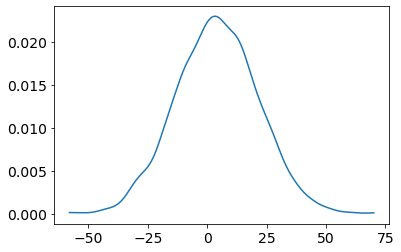

In [175]:
def gen_posterior(row):
    mean =row['Intercept']
    sigma = row['score_pct_change_sigma']
    school_mean = row['1|school_id'] 
    return np.random.normal(mean + school_mean,sigma)

data = school6_draws.apply(gen_posterior,axis=1)
print(np.mean(data))
print(np.std(data))
az.plot_dist(data)

Sames shit

### Bayes School

The actual school chosen here doesnt matter if we dont include group specific effects

6.501427112522708
16.75679250576589


<AxesSubplot:>

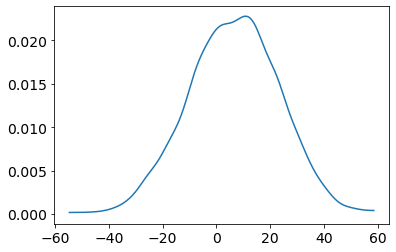

In [242]:
schoolnew = model.predict(results, kind='pps', data = pd.DataFrame({'school_id' : [6]}),include_group_specific=False, inplace=False)
data = schoolnew.posterior_predictive.score_pct_change.values.flatten()
print(np.mean(data))
print(np.std(data))
az.plot_dist(data)

Now lets look at all the schools

In [11]:
schoolall = model.predict(results, kind='pps', data = pd.DataFrame({'school_id' :grouped_pct_change.index}),include_group_specific=True, inplace=False)

In [174]:
school_pp = schoolall.posterior_predictive

In [54]:
# We can conver the dataset to a data frame.  Note that for each draw we ahave a posteror draw for each school.  
# Note this is a multi index so i flatten it
school_pp_df = school_pp.to_dataframe().reset_index().rename(columns = {'score_pct_change_dim_0':'school_index'})
school_pp_df = school_pp_df.drop(columns =['chain','draw']).sort_values('school_index').reset_index(drop=True)
school_pp_df.head()

,school_index,score_pct_change
0,0,13.981747
1,0,3.233407
2,0,31.113240
3,0,15.431646
4,0,31.161777


Note that school index is the index into the array sorted by school performance not *not* the school id!

Now we can use this to do stuff, like compute posterior predictive means and standard devations.

In [86]:
sumstats = school_pp_df.groupby('school_index').agg(['mean',np.std,lambda x :np.quantile(x,.1),lambda x :np.quantile(x,.9)])
sumstats.columns = ['mean','std','perc10','perc90']
sumstats

,mean,std,perc10,perc90
school_index,,,,
0,8.617121,16.809935,-13.005730,29.956507
1,8.728073,17.353546,-13.197473,30.761422
2,8.075811,17.498173,-14.114663,30.352562
3,8.518770,17.149770,-13.175292,30.872144
4,7.975320,17.106461,-14.063012,30.183749
5,7.726531,17.297897,-14.042549,29.528186
6,7.222796,17.175260,-14.638580,28.839686
7,6.580721,17.262702,-15.301865,28.702224
8,6.611812,17.069345,-15.451892,28.058835


<AxesSubplot:xlabel='score_pct_change', ylabel='Density'>

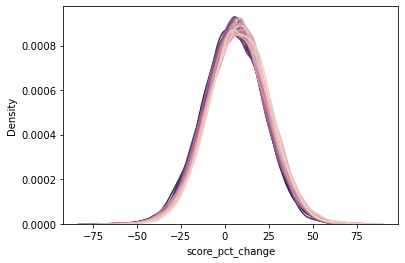

In [63]:
sns.kdeplot(data=school_pp_df, x='score_pct_change', hue='school_index', legend=None)

Not sure what there is to discuss, there is a lot of variability within schools so the results overlap quite a bit. Might be more interesting to look at the posterior means. This data is already in the posterior draws so we can directly look at it. Note here 'school_id' is school id, not the sorted version used above.

In [203]:
school_post_means_df2 = results.posterior.to_dataframe().reset_index()[['Intercept','school_id__factor_dim','1|school_id']]
school_post_means_df2['mean_improv'] = school_post_means_df2['Intercept'] + school_post_means_df2['1|school_id']
school_post_means_df2.drop(columns = ['Intercept','1|school_id'], inplace=True)
school_post_means_df2.rename(columns = {'school_id__factor_dim':'school_id'},inplace=True)
school_post_means_df2['school_id'] = school_post_means_df2['school_id'].astype('int')

sumstats = school_post_means_df2.groupby('school_id').agg(['mean',np.std,lambda x :np.quantile(x,.1),lambda x :np.quantile(x,.9)])
sumstats.columns = ['mean','std','perc10','perc90']
sumstats.sort_values('mean')

,mean,std,perc10,perc90
school_id,,,,
6,4.346221,2.819834,0.532590,7.514857
14,4.466907,2.771624,0.615937,7.467773
34,4.525243,2.791547,0.788607,7.611053
41,4.820799,2.720323,1.253248,7.766090
37,4.971792,2.582156,1.469541,7.821068
10,5.386020,2.366203,2.243272,8.158373
44,5.416904,2.542877,2.193362,8.296883
43,5.568514,2.407751,2.453415,8.318886
21,5.578756,2.419883,2.468413,8.394318


<AxesSubplot:xlabel='mean_improv', ylabel='Density'>

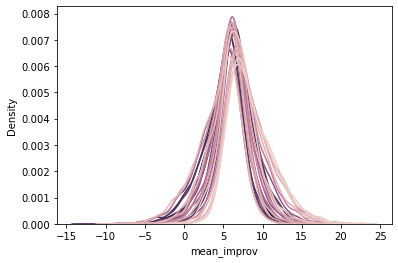

In [201]:
sns.kdeplot(data=school_post_means_df2, x='mean_improv', hue='school_id', legend=None, hue_order=grouped_pct_change.index.values)

So looking at the posterior means (without random error) we still have a quite a bit of uncertainty (error) in the means. Of course this was already summarized in the az.summary

## Exercise 16.12

Rather then use the plots, which I dont want to figure out how to do in python at the moment, we can simply look at the predicted means vs the unpooled means. 

In [70]:
def get_school_post_mean(id):
    return sum_80.loc[f'1|school_id[{id}]','mean'] + mu

This is really way more messy then i would expect for this kind of calculation

In [73]:
grouped_pct_change['posterior_mean'] = grouped_pct_change.reset_index()['school_id'].apply(get_school_post_mean).values

In [74]:
grouped_pct_change.tail()

,mean,std,posterior_mean
school_id,,,
37,0.812528,20.196544,4.954
41,-0.100181,12.473635,4.811
14,-1.351885,10.720369,4.462
34,-1.359764,6.021823,4.471
6,-1.660463,16.319153,4.400


Note here where i reset the index twice, first to get a normal index, and then to move *that* index into a column so that the schools are in order of increasing mean.

In [202]:
comparison_data = grouped_pct_change.reset_index().reset_index()[['index','mean','posterior_mean']]
comparison_data = comparison_data.melt(id_vars='index')


<AxesSubplot:xlabel='index', ylabel='value'>

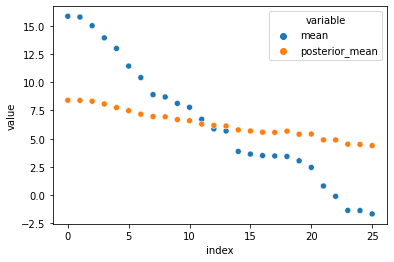

In [203]:
sns.scatterplot(data = comparison_data,x='index', y='value',hue='variable')

This demonstrates quite well the shrinkage effect.